# The Merton Partial Integro-Differential Equation


In this notebook we only consider the problem of solving the Merton PIDE.    
Let us recall that, this is the pricing PIDE associated to the process:   

\begin{equation}
\label{MertonM}
X_t = \mu t + \sigma W_t + \sum_{i=1}^{N_t} Y_i, 
\end{equation}

where $N_t$ is a Poisson random variable representing the number of jumps of $X_t$ up to time $t$, and $Y_i \sim \mathcal{N}(\alpha, \xi^2)$ is the size of each jump.

This is an **incomplete model**. It means that the risk neutral measure is not unique.    
In the following, we will adopt the choice (proposed by Merton) that, when changing from the physical to the risk neutral measure, only the drift is changed, while the other ingredients are unchanged.    
The risk neutral process has drift:

$$ \mu = r - \frac{1}{2} \sigma^2 - m $$
 
with $r$ risk free interest rate, and $m$ defined below.

##### Closed formula
Just for information, there exists a closed formula for pricing European call/put options under the Merton model.
This formula was presented by Merton in [2]. We just report it without derivation.

$$ \sum_k \frac{e^{-\psi T} \psi T}{k!} \; V^{BS}\biggl( S_0,\, T,\, r - m + \frac{k (\alpha + \xi^2/2)}{T}  ,\, \sqrt{\sigma^2 + \frac{k \xi^2}{T}} \biggr)  $$ 

with $\psi = \lambda \bigl( e^{\alpha + \frac{1}{2} \xi^2} \bigr)$, and $V^{BS}(S,T,r,\sigma)$ is the Black-Scholes closed formula.

<a id='sec1'></a>
## The Merton PIDE

In this notebook I want to show how to solve the Merton PIDE:   

\begin{align}
  \frac{\partial V(t,x)}{\partial t}
          + \biggl( r -\frac{1}{2}\sigma^2 -m \biggr) \frac{\partial V(t,x)}{\partial x}
          + \frac{1}{2} \sigma^2 \frac{\partial^2 V(t,x)}{\partial x^2} 
          + \int_{\mathbb{R}} V(t,x+z) \nu(dz) - (\lambda+r) V(t,x)  = 0.
\end{align}

with
\begin{align} 
 m :=& \; \int_{\mathbb{R}} ( e^{z} - 1 ) \nu(dz) \\
    =& \; \lambda \biggl( e^{\alpha + \frac{1}{2} \xi^2} -1 \biggr).
\end{align}

The Lévy measure is:
$$ \nu(dz) = \frac{\lambda}{\xi \sqrt{2\pi}} e^{- \frac{(z-\alpha)^2}{2\xi^2}} dz.  $$

This equation is an "extension" of the Black-Scholes equation. It coincides with the BS equation for $\lambda = 0$.

Let us first introduce the discretization method, and then write everything in python!

<a id='sec1.1'></a>
### Discretization

The discretization of this equation is quite similar to the discretization of the BS equation.   
However, here there is an additional integral term!!

We will adopt the Implicit-Explicit **(IMEX)** scheme proposed by Cont-Voltchkova [1]. The differential part is discretized by an implicit scheme (the same approach used for the BS equation). The integral part in instead discretized by an explicit scheme. The reason of the explicit choice, is that it avoids the inversion of the dense "jump" matrix (below we will construct the jump matrix).

The integral part is computed using **fourier methods** (it is a convolution integral) in order to increasing the efficiency.

Since we have to restrict the problem to a bounded region, we consider the equation:  

\begin{align*}
  \frac{\partial V(t,x)}{\partial t} 
          + \biggl( r -\frac{1}{2}\sigma^2 - \hat m \biggr) \frac{\partial V(t,x)}{\partial x} 
          + \frac{1}{2} \sigma^2 \frac{\partial^2 V(t,x)}{\partial x^2} 
          + \int_{-B_1}^{B_2} V(t,x+z) \nu(dz) - (\hat \lambda + r) V(t,x)  = 0.
\end{align*}

with   

$$ \hat m = \int_{-B_1}^{B_2} \bigl( e^z-1 \bigr) \nu(dz)$$ 
and 
$$\hat \lambda = \int_{-B_1}^{B_2} \nu(dz).$$

For $0 < K_1 < K_2$ we choose $B_1,B_2$ such that $ \bigl[-B_1,B_2\bigr] = \bigl[ ( -K_1-1/2 )\Delta x , ( K_2+1/2 )\Delta x \bigr] $, and $\Delta x$ is the space step.  

The computational domain of interest becomes $[0,T]\, \times \, [A_1-B_1,A_2+B_2]$, where in the regions $[0,T]\, \times \, [A_1-B_1,A_1]$ and 
$[0,T]\, \times \, [A_2,A_2+B_2]$ we need to define the boundary conditions.

Let us discretize the integral as follows:

$$ \int_{-B_1}^{B_2}  V(t_n,x_i+z) \nu(dz) \approx \sum_{k = -K_1}^{K_2} \nu_k V^{n}_{i+k} $$

where

$$
 \nu_k = \int_{(k-\frac{1}{2}) \Delta x}^{(k+\frac{1}{2}) \Delta x} \nu(z) dz, \hspace{1em} \mbox{ for } \hspace{1em} -K_1 \leq k \leq K_2. 
$$

We have that $ \hat \lambda = \sum_{k = -K_1}^{K_2} \nu_k $. For large values of $B_1$ and $B_2$, the parameter $\hat \lambda$ is a good approximation for $\lambda$, since

$$\lambda = \lim_{B_1,B_2 \to \infty} \hat \lambda = \lim_{B_1,B_2 \to \infty} \int_{-B_1}^{B_2} \nu(dz). $$

The discretized equation using the IMEX scheme becomes:   

$$ \begin{aligned}
&\frac{V^{n+1}_{i} -V^{n}_{i}}{\Delta t} + 
(r-\frac{1}{2}\sigma^2 - \hat m) \frac{V^{n}_{i+1} -V^{n}_{i-1}}{ 2 \Delta x} \\ \nonumber
&+ \frac{1}{2} \sigma^2 \frac{V^{n}_{i+1} + V^{n}_{i-1} - 2 V^{n}_{i}}{\Delta x^2}  - (r+\hat \lambda) V^{n}_i +\sum_{k = -K_1}^{K_2} \nu_k V^{n+1}_{i+k} = 0.
\end{aligned} $$

Rearranging the terms: 

$$ \begin{aligned}
\underbrace{ V^{n+1}_{i} + \Delta t \sum_{k = -K_1}^{K_2} \nu_k V^{n+1}_{i+k} }_{\tilde V^{n+1}_i} &= 
	V^{n}_{i} \biggl( 1 + (r+\hat \lambda)\Delta t + \sigma^2 \frac{\Delta t}{\Delta x^2} \biggr)  \\
& + V^{n}_{i+1} \biggl( -(r -\frac{1}{2}\sigma^2 -\hat m )\frac{\Delta t}{2 \Delta x} +
\frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta x^2}  \biggr)  \\
& + V^{n}_{i-1} \biggl( (r -\frac{1}{2}\sigma^2 - \hat m)\frac{\Delta t}{2 \Delta x} + 
\frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta x^2}  \biggr).
\end{aligned} $$

We can rename the coefficients:

$$ \tilde V^{n+1}_{i} = a V^{n}_{i-1} + b V^{n}_{i} + c V^{n}_{i+1}, $$

and solve the system for $V^{n}_{i}$,  for every $1 \leq i \leq M-1$:

$$
 \begin{cases}
  \tilde V^{n+1}_i = V^{n+1}_{i} + \Delta t \sum_{k = -K_1}^{K_2} V^{n+1}_{i+k} \nu_k \quad \mbox{ for } \quad 1 \leq i \leq M-1 \\
  V^{n} = \mathcal{D}^{-1} \biggl( \tilde V^{n+1} - B \biggr)   
 \end{cases}
$$

where $\mathcal{D}$ is the tridiagonal matrix formed by the coefficients $a,b,c$, and with boundary terms $B = (a V^{n}_{0}, 0, ... , 0, c V^{n}_{M})$.  

Introducing the *jump* matrix $J$, the system becomes:

$$
 \begin{cases}
  \tilde V^{n+1} = V^{n+1} + \Delta t \, J \, V^{n+1} \\
  V^{n} = \mathcal{D}^{-1} \biggl( \tilde V^{n+1} - B \biggr) %\quad \mbox{ for } \quad 1 \leq i \leq M-1.  
 \end{cases}
$$

However, we will see that it is better to avoid to use this matrix, and solve the integral by **fft** methods.

<a id='sec2'></a>
## Numerical solution of the PIDE

Ok... we are ready to implement the previous algorithm.  

In order to have a clear presentation, I prefer to choose a small number of time and space steps. It will be easier for you to follow what I'm doing.


In [13]:
from scipy import sparse
from scipy.sparse.linalg import splu

import numpy as np
import scipy as scp
import scipy.stats as ss
from IPython.display import display
import sympy; sympy.init_printing()
from scipy import signal
from scipy.integrate import quad
import matplotlib.pyplot as plt

def display_matrix(m):
    display(sympy.Matrix(m))

In [5]:
r = 0.1; sig = 0.2          # risk free rate and diffusion coefficient      
S0 = 100; X0 = np.log(S0)   # spot price and log-price       
K = 100; Texpir = 1         # strike and maturity            

lam = 0.8   # lambda 
muJ = 0     # (or alpha) is the mean of the jump size 
sigJ = 0.5  # (or xi) is the standard deviation of the jump size 

Nspace = 5   # M space steps 
Ntime = 3    # N time steps 
S_max = 3*float(K)                
S_min = float(K)/3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

dev_X = np.sqrt(lam * sigJ**2 + lam * muJ**2)   # std dev of the jump component

dx = (x_max - x_min)/(Nspace-1)
extraP = int(np.floor(3*dev_X/dx))  # extra points
x = np.linspace(x_min-extraP*dx, x_max+extraP*dx, Nspace + 2*extraP)   # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)       # time discretization

What I did was: 
- define tha parameters. 
  I called muJ and sigJ the mean and standard deviation of the (normal) jump random variables. They correspond to        $\alpha$ and $\xi$. 
- obtain the boundary values: A1 and A2. And the space step *dx* and time step *dt*.
  The variable `x` takes values in the extended computational domain $[A_1-B_1, A_2+B_2]$. 
- compute the standard deviation of the jump component (at $t=1$). Let us recall the variance formula for the compound Poisson process (obtained from the formula of conditional variance):
$$ Var \biggl[ \sum_{i=1}^{N_t} Y_i \biggr] = \lambda (\alpha^2 + \xi^2) t $$
- compute the extra points *extraP* indicating the number of points to use as extra bounday conditions. The extra points are the points in the regions $[A_1 - B_1, A_1]$ and $[A_2, A_2 + B_2]$.

Why did I choose the extra points in that way?

The idea is that we want to cover at least 3 standard deviations of the domain of the Lévy measure. The choice of 3 is arbitrary. The higher is the better.     
The important fact to remember, is that the smaller is $\Delta X$, the higher is *extraP*. 

In [6]:
print("Under this discretization there are {} extra points".format(extraP))

Under this discretization there are 2 extra points


In [8]:
Payoff = np.maximum(np.exp(x)-K,0)             # Call payoff
V = np.zeros((Nspace + 2*extraP, Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms

V[:,-1] = Payoff                   # terminal conditions 
V[-extraP-1:,:] = np.exp(x[-extraP-1:]).reshape(extraP+1,1) * np.ones((extraP+1,Ntime)) - \
                 K * np.exp(-r* T[::-1] ) * np.ones((extraP+1,Ntime))  # boundary conditions for the call  
V[:extraP+1,:] = 0

display_matrix(V.round(2))

⎡ 0.0     0.0     0.0  ⎤
⎢                      ⎥
⎢ 0.0     0.0     0.0  ⎥
⎢                      ⎥
⎢ 0.0     0.0     0.0  ⎥
⎢                      ⎥
⎢ 0.0     0.0     0.0  ⎥
⎢                      ⎥
⎢ 0.0     0.0     0.0  ⎥
⎢                      ⎥
⎢ 0.0     0.0    73.21 ⎥
⎢                      ⎥
⎢209.52  204.88  200.0 ⎥
⎢                      ⎥
⎢429.13  424.49  419.62⎥
⎢                      ⎥
⎣809.52  804.88  800.0 ⎦

In the previous cell we created the grid for $V$.     
The time grows from left to right. The stock price grows from up to down.

- The first 2 rows, and the last 2, are the extra boundary conditions. (In agreement with extraP)
- The third row and the seventh row are the usual boudary conditions.
- The last column corresponds to the terminal boundary condition.

Let us create the vector $\nu_k$:

In [17]:
cdf = ss.norm.cdf([np.linspace(-(extraP+1+0.5)*dx, (extraP+1+0.5)*dx, 2*(extraP+2) )], loc=muJ, scale=sigJ)[0]
nu = lam * (cdf[1:] - cdf[:-1])
print(nu)

[0.00236098 0.03733859 0.19337038 0.3337637  0.19337038 0.03733859
 0.00236098]


The integral:
$$ \hat m = \int_{-B_1}^{B_2} \bigl( e^z-1 \bigr) \nu(dz)$$ 
can be computed using two methods:
- or using the scipy function `quad`
- or using the discretization:
$$  \hat m \approx \sum_{k = -K_1}^{K_2} (e^{k \Delta x}-1) \nu_k  $$

These two methods are equivalent. We show both in the next cell. Of course the values are different because $\Delta x$ is quite big now.

In [18]:
lam_appr = sum(nu)    # sum of the components of nu
print("Truncated jump activity: ", lam_appr)

m = lam * (np.exp(muJ + (sigJ**2)/2) -1)     # coefficient m
print("True value: ", m)
m_int = quad(lambda z: lam * (np.exp(z)-1) * ss.norm.pdf(z,muJ,sigJ), -(extraP+1.5)*dx, (extraP+1.5)*dx )[0]
print("Truncated value, using quad: ", m_int)
m_appr = np.array([ np.exp(i*dx)-1 for i in range(-(extraP+1), extraP+2)]) @ nu
print("Approximation value: ", m_appr)

Truncated jump activity:  0.7999036142791525
True value:  0.10651876245346106
Truncated value, using quad:  0.10623607827426487
Approximation value:  0.11761420996944338


In [23]:
# construction of the tri-diagonal matrix D
sig2 = sig*sig; dxx = dx * dx
a = ( (dt/2) * ( (r-m_appr-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r + lam_appr) )
c = (-(dt/2) * ( (r-m_appr-0.5*sig2)/dx + sig2/dxx ) )
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
DD = splu(D)

In the previous cell we created the "diffusion" matrix, in the same way we did for the Black-Scholes equation in the notebook **2.1**.

In the next cell we create the "jump" matrix $J$. As you can see, it is a dense matrix!

In [24]:
J = np.zeros((Nspace-2, Nspace + 2*extraP))
for i in range(Nspace-2):
    J[i, i:(len(nu)+i)] = nu
display_matrix(J.round(4))

⎡0.0024  0.0373  0.1934  0.3338  0.1934  0.0373  0.0024   0.0     0.0  ⎤
⎢                                                                      ⎥
⎢ 0.0    0.0024  0.0373  0.1934  0.3338  0.1934  0.0373  0.0024   0.0  ⎥
⎢                                                                      ⎥
⎣ 0.0     0.0    0.0024  0.0373  0.1934  0.3338  0.1934  0.0373  0.0024⎦

We have all the ingredients to solve the backward in time algorithm:

In [31]:
# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[extraP,i]
    offset[-1] = c * V[-1-extraP,i]
    V_jump = V[extraP+1 : -extraP-1, i+1] + dt * (J @ V[:,i+1])
    V[extraP+1 : -extraP-1, i] = DD.solve( V_jump - offset )    

# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print(oPrice)

15.205937181777447


#### Is the previous method efficient?

Well NO!

Since the integral we are considering is a convolution integral, we should take advantage of the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem).

We can use two python functions:
- [fftconvolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html#scipy.signal.fftconvolve) Convolves two arrays using FFT.
- [convolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html) Convolves two arrays. The user can specify the method. If the length of the array is smaller than 500 it is better to use the definition of convolution, otherwise it is better to use the FFT (and it calls fftconvolve).

Let us check that the output is the same:

In [29]:
# example
from scipy import signal

print(signal.fftconvolve(V[:,-1], nu, mode="valid"))
print(J @ V[:,-1])

[ 3.2055702  22.61411538 80.66390056]
[ 3.2055702  22.61411538 80.66390056]


In [30]:
# Backward iteration using fftconvolve:
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[extraP,i]
    offset[-1] = c * V[-1-extraP,i]
    V_jump = V[extraP+1 : -extraP-1, i+1] + dt * signal.fftconvolve(V[:,i+1], nu, mode="valid")
    V[extraP+1 : -extraP-1, i] = DD.solve( V_jump - offset )    

# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print(oPrice)

15.20593718177744


<a id='sec3'></a>
## Comparison with other numerical methods


In the class `Merton_pricer` I made the following choice for the parameters:    
```python
        S_max = 6*float(self.K)                
        S_min = float(self.K)/6
```
and
```python
extraP = int(np.floor(5*dev_X/dx))
```
The reason is that I want the parameters $A_1$, $A_2$, $B_1$, $B_2$ to be as large as possible.

In the backward iteration I used the FFT approach:

```python
V_jump = V[extraP+1 : -extraP-1, i+1] + dt * signal.convolve(V[:,i+1],nu[::-1],mode="valid",method="fft")
```

The correct code to use is `nu[::-1]`.    
This is because our convolution has the form
$\sum_{k = -K_1}^{K_2} \nu_k V^{n}_{i+k}$, but the convolution in the [numpy.convolve](https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html) function is defined as
$\sum_{k = -K_1}^{K_2} \nu_k V^{n}_{i-k}$. Therefore it is necessary to invert the vector!    
(In the code above, I did not invert `nu` for clarity. The code worked because the considered `nu` was symmetric).

Let us compare the solution of the Merton PIDE with other numerical methods: 

In [2]:
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process, Merton_process
from functions.BS_pricer import BS_pricer
from functions.Merton_pricer import Merton_pricer 

In [3]:
# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="call" )
opt_param_p = Option_param(S0=100, K=100, T=1, exercise="European", payoff="put" )

Merton_param = Merton_process(r=0.1, sig=0.2, lam=0.8, muJ=0, sigJ=0.5)
Merton = Merton_pricer(opt_param, Merton_param)
Merton_p = Merton_pricer(opt_param_p, Merton_param)

**PIDE price:**

In [3]:
Merton.PIDE_price((12000,10000), Time=True)

(22.01403904360017, 40.36621618270874)

**Closed formula:**

In [4]:
Merton.closed_formula()

22.016367621905697

**Fourier inversion:**

In [3]:
Merton.Fourier_inversion()

22.0163676219057

**Monte Carlo** method gives the value: (the output includes the price, the standard error and the execution time)

In [4]:
Merton.MC(1000000, Err=True, Time=True)

(22.01260319665876, 0.05643812936401397, 64.60239958763123)

Plot of the call:

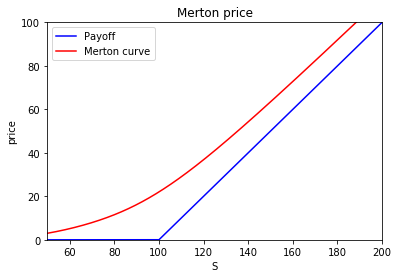

In [20]:
Merton.plot([50,200,0,100])

Plot of the put:

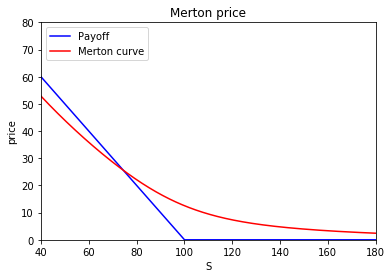

In [27]:
Merton_p.plot([40,180,0,80])

But what happens if we select some "strange" set of parameters?    
Let's try.

In [11]:
Merton_param = Merton_process(r=0.1, sig=0.1, lam=0.1, muJ=0, sigJ=3.1)
Merton = Merton_pricer(opt_param, Merton_param)

print( "PIDEprice: ", Merton.PIDE_price((12000,10000)) )
print( "Closed formula: ", Merton.closed_formula() )
print( "Monte Carlo price and std error: ", Merton.MC(500000, Err=True) )

PIDEprice:  50.19209080990695
Closed formula:  92.84579753439006
Monte Carlo price and std error:  (0.021836642589105403, 0.010662297105708677)


What happened?     
Three methods... three different outputs.  This is not good. 

Do not worry. The model is fine. And the algorithms are fine too.     
The last set of parameters is the problem.    
To be precise, the model is fine under a certain set of parameters. Let us investigate this feature.

<a id='sec5'></a>
## Comparison with the Black Scholes PDE

Now let us compare the Merton curve with the Black Scholes curve, for a European call option.    
The volatility of the BS model is chosen equal to the standard deviation of the Merton process. 

Looking at the plot we can see the different shape of the two curves.

In [28]:
# Creates the object with the parameters of the option
opt_param_c = Option_param(S0=100, K=100, T=1, exercise="European", payoff="call" )

# Creates the object with the parameters of the process
Merton_param = Merton_process(r=0.1, sig=0.2, lam=1.2, muJ=0, sigJ=0.8)
diff_param = Diffusion_process(r=0.1, sig=np.sqrt(Merton_param.var))

print("standard deviation: ", np.sqrt(Merton_param.var) )
print("kurtosis: ", Merton_param.kurt)

# Creates the object of the pricer: call
BS_c = BS_pricer(opt_param_c, diff_param)
Merton_c = Merton_pricer(opt_param_c, Merton_param)

standard deviation:  0.8988882021697694
kurtosis:  2.823252622291932


In [29]:
print("Merton closed formula, call: ", Merton_c.closed_formula() )
print("BS closed formula, call: ", BS_c.closed_formula() )

Merton closed formula, call:  39.525220975930694
BS closed formula, call:  37.987106518471414


In [30]:
print("Merton PIDE call:", Merton_c.PIDE_price((13000,10000)))
print("BS PDE call:", BS_c.PDE_price((8000,5000)) ) 

Merton PIDE call: 39.4908331514349
BS PDE call: 37.9848259795486


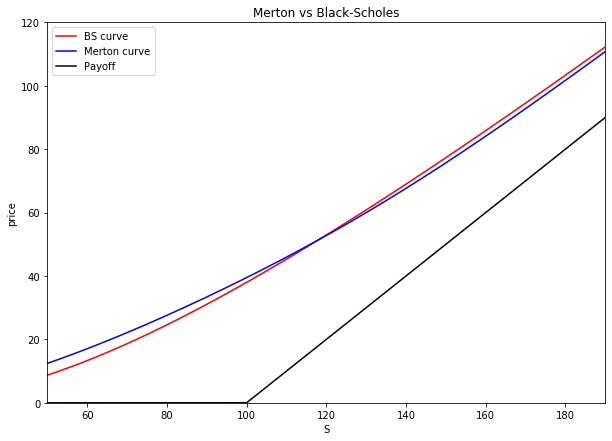

In [32]:
plt.figure(figsize=(10,7))
plt.plot(BS_c.S_vec, BS_c.price_vec, color='red',label="BS curve")
plt.plot(Merton_c.S_vec, Merton_c.price_vec, color='blue',label="Merton curve")
plt.plot(Merton_c.S_vec, Merton_c.payoff_f(Merton_c.S_vec), color='black',label="Payoff")
plt.axis([50,190,0,120])
plt.xlabel("S"); plt.ylabel("price"); plt.title("Merton vs Black-Scholes")
plt.legend()
plt.plot()

# References

[1] Cont-Voltchkova (2005), "Integro-differential equations for option prices in exponential Lévy models", Finance and Stochastics, 9, 299--325.

[2] Merton, R. (1976). "Option pricing when underlying stock returns are discontinuous", Journal of Financial Economics, 3, 125--144.